<a href="https://colab.research.google.com/github/Mbashas/data_decisions/blob/main/malaria_shortcut_learning_v2.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# 🦟 Shortcut Learning in Malaria Detection
## Investigating YOLO Generalization from Thin to Thick Blood Smears

**Research Question:** To what extent do YOLO-based models trained only on Ghana thin blood-smear images fail to generalize to Ghana thick blood-smear images, and what does this performance gap reveal about their reliance on smear-level visual shortcuts rather than parasite morphology?

---

### Notebook Structure
1. **Setup** - Mount Drive, install packages, verify GPU
2. **Data Preparation** - Reorganize dataset into YOLO format
3. **Data Exploration** - Visualize thin vs thick smear differences
4. **Model Training** - Train YOLOv8 on thin smears only
5. **Evaluation** - Test on both thin (ID) and thick (OOD) smears
6. **Attribution Analysis** - Grad-CAM heatmaps to visualize attention
7. **Results & Visualization** - Publication-ready figures

---

## 1. Setup & Configuration

In [ ]:
# Mount Google Drive
from google.colab import drive
drive.mount('/content/drive')
print("✓ Drive mounted!")

Mounted at /content/drive
✓ Drive mounted!


In [ ]:
# Install required packages
!pip install ultralytics -q
!pip install grad-cam -q

print("✓ Packages installed!")

✓ Packages installed!


In [ ]:
# Verify GPU availability
import torch

if torch.cuda.is_available():
    print(f"✓ GPU Available: {torch.cuda.get_device_name(0)}")
    print(f"  Memory: {torch.cuda.get_device_properties(0).total_memory / 1e9:.1f} GB")
else:
    print("✗ No GPU! Go to: Runtime → Change runtime type → T4 GPU")

✓ GPU Available: Tesla T4
  Memory: 15.8 GB


In [ ]:
# ============================================================================
# CONFIGURATION - YOUR PATHS
# ============================================================================

# Your existing dataset location on Drive
DRIVE_ROOT = "/content/drive/MyDrive/Datasets"

# Source paths (your current structure)
THIN_IMAGES_SRC = f"{DRIVE_ROOT}/Thin Images With Annotations/Thin Images Ghana/images"
THIN_LABELS_SRC = f"{DRIVE_ROOT}/Thin Images With Annotations/Thin Images Ghana/labels_yolo"
THICK_IMAGES_SRC = f"{DRIVE_ROOT}/Ghana/Thick/images"
THICK_LABELS_SRC = f"{DRIVE_ROOT}/Ghana/Thick/labels_yolo"

# Output paths (where we'll create YOLO-formatted data)
OUTPUT_ROOT = f"{DRIVE_ROOT}/malaria_yolo_ready"
RESULTS_DIR = f"{DRIVE_ROOT}/malaria_results"

# Training parameters
EPOCHS = 50
IMAGE_SIZE = 640
BATCH_SIZE = -1  # Auto-detect
MODEL_SIZE = "n"  # n=nano (fastest), s=small, m=medium
TRAIN_SPLIT = 0.8  # 80% train, 20% val

# Class names
CLASS_NAMES = {
    0: "gametocyte",
    1: "trophozoite",
    2: "other_stage",
    3: "white_blood_cell",
    4: "artefacts",
    5: "ring_stage"
}

print("Configuration set!")

Configuration set!


In [ ]:
# Verify your source paths exist
import os

print("Checking your dataset paths...\n")

paths = [
    ("Thin Images", THIN_IMAGES_SRC),
    ("Thin Labels", THIN_LABELS_SRC),
    ("Thick Images", THICK_IMAGES_SRC),
    ("Thick Labels", THICK_LABELS_SRC),
]

all_ok = True
for name, path in paths:
    if os.path.exists(path):
        count = len(os.listdir(path))
        print(f"✓ {name}: {count} files")
    else:
        print(f"✗ {name}: NOT FOUND")
        print(f"  Expected: {path}")
        all_ok = False

if all_ok:
    print("\n✓ All paths found! Ready to proceed.")
else:
    print("\n⚠️ Some paths not found. Check DRIVE_ROOT in the config above.")

Checking your dataset paths...

✓ Thin Images: 1011 files
✓ Thin Labels: 1011 files
✓ Thick Images: 3045 files
✓ Thick Labels: 3045 files

✓ All paths found! Ready to proceed.


## 2. Data Preparation

Reorganize your dataset into YOLO format with train/val splits. This runs directly on Drive (~30 seconds).

In [ ]:
import os
import shutil
import random
from glob import glob

def reorganize_dataset():
    """Reorganize dataset into YOLO format with train/val split."""

    print("="*60)
    print("REORGANIZING DATASET FOR YOLO")
    print("="*60)

    # Create output directories
    dirs_to_create = [
        f"{OUTPUT_ROOT}/thin_smear/train/images",
        f"{OUTPUT_ROOT}/thin_smear/train/labels",
        f"{OUTPUT_ROOT}/thin_smear/val/images",
        f"{OUTPUT_ROOT}/thin_smear/val/labels",
        f"{OUTPUT_ROOT}/thick_smear_test/images",
        f"{OUTPUT_ROOT}/thick_smear_test/labels",
    ]

    for d in dirs_to_create:
        os.makedirs(d, exist_ok=True)
    print("✓ Created output directories")

    # Get thin smear image-label pairs
    thin_images = glob(f"{THIN_IMAGES_SRC}/*.[jJ][pP][gG]") + \
                  glob(f"{THIN_IMAGES_SRC}/*.[pP][nN][gG]") + \
                  glob(f"{THIN_IMAGES_SRC}/*.[jJ][pP][eE][gG]")

    print(f"\nFound {len(thin_images)} thin smear images")

    # Match with labels and create pairs
    pairs = []
    for img_path in thin_images:
        img_name = os.path.basename(img_path)
        label_name = os.path.splitext(img_name)[0] + ".txt"
        label_path = os.path.join(THIN_LABELS_SRC, label_name)

        if os.path.exists(label_path):
            pairs.append((img_path, label_path, img_name, label_name))

    print(f"Matched {len(pairs)} image-label pairs")

    # Shuffle and split
    random.seed(42)
    random.shuffle(pairs)

    split_idx = int(len(pairs) * TRAIN_SPLIT)
    train_pairs = pairs[:split_idx]
    val_pairs = pairs[split_idx:]

    print(f"Split: {len(train_pairs)} train, {len(val_pairs)} val")

    # Copy thin smear files
    print("\nCopying thin smear files...")
    for img_path, label_path, img_name, label_name in train_pairs:
        shutil.copy2(img_path, f"{OUTPUT_ROOT}/thin_smear/train/images/{img_name}")
        shutil.copy2(label_path, f"{OUTPUT_ROOT}/thin_smear/train/labels/{label_name}")

    for img_path, label_path, img_name, label_name in val_pairs:
        shutil.copy2(img_path, f"{OUTPUT_ROOT}/thin_smear/val/images/{img_name}")
        shutil.copy2(label_path, f"{OUTPUT_ROOT}/thin_smear/val/labels/{label_name}")

    print(f"✓ Copied thin smear files")

    # Copy thick smear files (all as test set)
    print("\nCopying thick smear files...")
    thick_images = glob(f"{THICK_IMAGES_SRC}/*.[jJ][pP][gG]") + \
                   glob(f"{THICK_IMAGES_SRC}/*.[pP][nN][gG]") + \
                   glob(f"{THICK_IMAGES_SRC}/*.[jJ][pP][eE][gG]")

    thick_count = 0
    for img_path in thick_images:
        img_name = os.path.basename(img_path)
        label_name = os.path.splitext(img_name)[0] + ".txt"
        label_path = os.path.join(THICK_LABELS_SRC, label_name)

        shutil.copy2(img_path, f"{OUTPUT_ROOT}/thick_smear_test/images/{img_name}")
        if os.path.exists(label_path):
            shutil.copy2(label_path, f"{OUTPUT_ROOT}/thick_smear_test/labels/{label_name}")
        thick_count += 1

    print(f"✓ Copied {thick_count} thick smear files")

    # Create YAML config files
    print("\nCreating YAML config files...")

    thin_yaml = f"""# Thin Smear Training Dataset
path: {OUTPUT_ROOT}/thin_smear
train: train/images
val: val/images

names:
  0: gametocyte
  1: trophozoite
  2: other_stage
  3: white_blood_cell
  4: artefacts
  5: ring_stage
"""

    thick_yaml = f"""# Thick Smear Test Dataset (OOD)
path: {OUTPUT_ROOT}/thick_smear_test
train: images
val: images

names:
  0: gametocyte
  1: trophozoite
  2: other_stage
  3: white_blood_cell
  4: artefacts
  5: ring_stage
"""

    with open(f"{OUTPUT_ROOT}/thin_smear.yaml", 'w') as f:
        f.write(thin_yaml)

    with open(f"{OUTPUT_ROOT}/thick_smear.yaml", 'w') as f:
        f.write(thick_yaml)

    print("✓ Created YAML configs")

    print("\n" + "="*60)
    print("✓ REORGANIZATION COMPLETE!")
    print("="*60)
    print(f"\nOutput: {OUTPUT_ROOT}")
    print(f"  - thin_smear/train: {len(train_pairs)} images")
    print(f"  - thin_smear/val: {len(val_pairs)} images")
    print(f"  - thick_smear_test: {thick_count} images")

    return len(train_pairs), len(val_pairs), thick_count

# Run reorganization
train_n, val_n, test_n = reorganize_dataset()

REORGANIZING DATASET FOR YOLO
✓ Created output directories

Found 1011 thin smear images
Matched 1011 image-label pairs
Split: 808 train, 203 val

Copying thin smear files...
✓ Copied thin smear files

Copying thick smear files...
✓ Copied 3045 thick smear files

Creating YAML config files...
✓ Created YAML configs

✓ REORGANIZATION COMPLETE!

Output: /content/drive/MyDrive/Datasets/malaria_yolo_ready
  - thin_smear/train: 808 images
  - thin_smear/val: 203 images
  - thick_smear_test: 3045 images


In [ ]:
# Set paths for the rest of the notebook
THIN_YAML = f"{OUTPUT_ROOT}/thin_smear.yaml"
THICK_YAML = f"{OUTPUT_ROOT}/thick_smear.yaml"

In [ ]:
# Set paths for the rest of the notebook
THIN_YAML = f"{OUTPUT_ROOT}/thin_smear.yaml"
THICK_YAML = f"{OUTPUT_ROOT}/thick_smear.yaml"

# Create results directory
os.makedirs(RESULTS_DIR, exist_ok=True)

print(f"Training config: {THIN_YAML}")
print(f"Test config: {THICK_YAML}")
print(f"Results will be saved to: {RESULTS_DIR}")

Training config: /content/drive/MyDrive/Datasets/malaria_yolo_ready/thin_smear.yaml
Test config: /content/drive/MyDrive/Datasets/malaria_yolo_ready/thick_smear.yaml
Results will be saved to: /content/drive/MyDrive/Datasets/malaria_results


## 3. Data Exploration

Visualize the key differences between thin and thick smears.

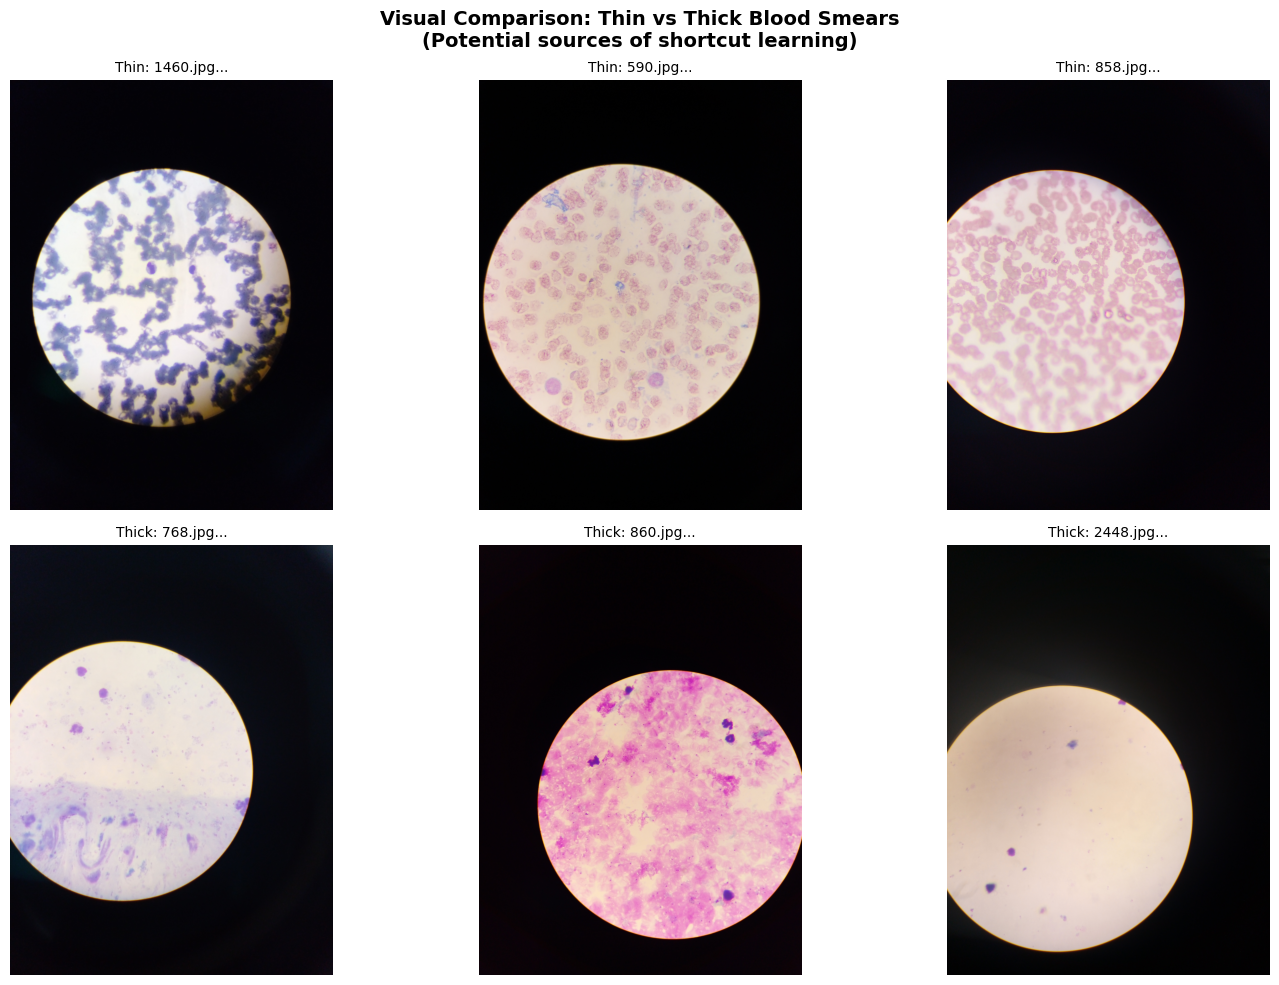


💡 Key Visual Differences (Potential Shortcuts):
  • Background: Pink cells (thin) vs lysed debris (thick)
  • Density: Sparse (thin) vs crowded (thick)
  • Staining: Different intensity patterns


In [ ]:
import matplotlib.pyplot as plt
import cv2
import numpy as np
import random
from glob import glob

def load_random_images(image_dir, n=3):
    """Load n random images from directory."""
    all_images = glob(f"{image_dir}/*.[jJ][pP][gG]") + \
                 glob(f"{image_dir}/*.[pP][nN][gG]")
    if not all_images:
        return []
    selected = random.sample(all_images, min(n, len(all_images)))
    images = []
    for path in selected:
        img = cv2.imread(path)
        if img is not None:
            img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
            images.append((img, os.path.basename(path)))
    return images

# Load samples
thin_samples = load_random_images(f"{OUTPUT_ROOT}/thin_smear/train/images", n=3)
thick_samples = load_random_images(f"{OUTPUT_ROOT}/thick_smear_test/images", n=3)

# Create comparison figure
fig, axes = plt.subplots(2, 3, figsize=(15, 10))

for i, (img, name) in enumerate(thin_samples):
    axes[0, i].imshow(img)
    axes[0, i].set_title(f"Thin: {name[:15]}...", fontsize=10)
    axes[0, i].axis('off')

for i, (img, name) in enumerate(thick_samples):
    axes[1, i].imshow(img)
    axes[1, i].set_title(f"Thick: {name[:15]}...", fontsize=10)
    axes[1, i].axis('off')

axes[0, 0].set_ylabel("THIN SMEARS\n(Training)", fontsize=12, fontweight='bold')
axes[1, 0].set_ylabel("THICK SMEARS\n(OOD Test)", fontsize=12, fontweight='bold')

plt.suptitle("Visual Comparison: Thin vs Thick Blood Smears\n(Potential sources of shortcut learning)",
             fontsize=14, fontweight='bold')
plt.tight_layout()
plt.savefig(f"{RESULTS_DIR}/thin_vs_thick_comparison.png", dpi=150, bbox_inches='tight')
plt.show()

print("\n💡 Key Visual Differences (Potential Shortcuts):")
print("  • Background: Pink cells (thin) vs lysed debris (thick)")
print("  • Density: Sparse (thin) vs crowded (thick)")
print("  • Staining: Different intensity patterns")

In [ ]:
# Dataset statistics
def count_objects(label_dir):
    """Count objects per class."""
    counts = {i: 0 for i in range(6)}
    for lf in glob(f"{label_dir}/*.txt"):
        with open(lf, 'r') as f:
            for line in f:
                parts = line.strip().split()
                if parts:
                    class_id = int(parts[0])
                    if class_id in counts:
                        counts[class_id] += 1
    return counts

# Count objects
thin_train_counts = count_objects(f"{OUTPUT_ROOT}/thin_smear/train/labels")
thin_val_counts = count_objects(f"{OUTPUT_ROOT}/thin_smear/val/labels")
thick_counts = count_objects(f"{OUTPUT_ROOT}/thick_smear_test/labels")

print("="*60)
print("CLASS DISTRIBUTION")
print("="*60)

print(f"\n{'Class':<20} {'Thin Train':<12} {'Thin Val':<12} {'Thick Test':<12}")
print("-"*60)

for class_id in range(6):
    name = CLASS_NAMES[class_id]
    print(f"{name:<20} {thin_train_counts[class_id]:<12} {thin_val_counts[class_id]:<12} {thick_counts[class_id]:<12}")

print("\n⚠️  NOTE: Thick smears only have gametocyte & trophozoite labels!")
print("   Cross-domain evaluation will focus on these two classes.")

CLASS DISTRIBUTION

Class                Thin Train   Thin Val     Thick Test  
------------------------------------------------------------
gametocyte           13265        3234         360900      
trophozoite          9358         3100         16266       
other_stage          1            0            0           
white_blood_cell     925          280          0           
artefacts            266          42           0           
ring_stage           10124        2864         0           

⚠️  NOTE: Thick smears only have gametocyte & trophozoite labels!
   Cross-domain evaluation will focus on these two classes.


## 4. Model Training

Train YOLOv8 **only on thin smears**. This takes ~15-25 minutes on a T4 GPU.

In [ ]:
from ultralytics import YOLO

In [ ]:
from ultralytics import YOLO

# Initialize model
model = YOLO(f"yolov8{MODEL_SIZE}.pt")

print(f"Model: YOLOv8{MODEL_SIZE}")
print(f"Training on: Thin smears only ({train_n} images)")
print(f"Validation: {val_n} images")
print(f"Epochs: {EPOCHS}")
print("\n🚀 Starting training...")

Creating new Ultralytics Settings v0.0.6 file ✅ 
View Ultralytics Settings with 'yolo settings' or at '/root/.config/Ultralytics/settings.json'
Update Settings with 'yolo settings key=value', i.e. 'yolo settings runs_dir=path/to/dir'. For help see https://docs.ultralytics.com/quickstart/#ultralytics-settings.


NameError: name 'MODEL_SIZE' is not defined

In [ ]:
# Train the model
results = model.train(
    data=THIN_YAML,
    epochs=EPOCHS,
    imgsz=IMAGE_SIZE,
    batch=BATCH_SIZE,
    project=RESULTS_DIR,
    name="thin_baseline",
    save_period=10,
    patience=15,
    plots=True,
    verbose=True,
)

print("\n" + "="*50)
print("✓ TRAINING COMPLETE!")
print("="*50)

Ultralytics 8.3.233 🚀 Python-3.12.12 torch-2.9.0+cu126 CUDA:0 (Tesla T4, 15095MiB)
engine/trainer: agnostic_nms=False, amp=True, augment=False, auto_augment=randaugment, batch=-1, bgr=0.0, box=7.5, cache=False, cfg=None, classes=None, close_mosaic=10, cls=0.5, compile=False, conf=None, copy_paste=0.0, copy_paste_mode=flip, cos_lr=False, cutmix=0.0, data=/content/drive/MyDrive/Datasets/malaria_yolo_ready/thin_smear.yaml, degrees=0.0, deterministic=True, device=None, dfl=1.5, dnn=False, dropout=0.0, dynamic=False, embed=None, epochs=50, erasing=0.4, exist_ok=False, fliplr=0.5, flipud=0.0, format=torchscript, fraction=1.0, freeze=None, half=False, hsv_h=0.015, hsv_s=0.7, hsv_v=0.4, imgsz=640, int8=False, iou=0.7, keras=False, kobj=1.0, line_width=None, lr0=0.01, lrf=0.01, mask_ratio=4, max_det=300, mixup=0.0, mode=train, model=yolov8n.pt, momentum=0.937, mosaic=1.0, multi_scale=False, name=thin_baseline, nbs=64, nms=False, opset=None, optimize=False, optimizer=auto, overlap_mask=True, pat

In [ ]:
# If training interrupted, resume with:
# model = YOLO(f"{RESULTS_DIR}/thin_baseline/weights/last.pt")
# results = model.train(resume=True)

## 5. Evaluation: ID vs OOD

Compare performance on thin smears (in-distribution) vs thick smears (out-of-distribution).

In [ ]:
# Load best model
# Re-define necessary variables in case the configuration cell was not run
DRIVE_ROOT = "/content/drive/MyDrive/Datasets"
RESULTS_DIR = f"{DRIVE_ROOT}/malaria_results"

best_model_path = f"{RESULTS_DIR}/thin_baseline/weights/best.pt"
model = YOLO(best_model_path)
print(f"Loaded: {best_model_path}")

Loaded: /content/drive/MyDrive/Datasets/malaria_results/thin_baseline/weights/best.pt


In [ ]:
# Evaluate on thin smears (ID)
print("="*60)
print("EVALUATING ON THIN SMEARS (In-Distribution)")
print("="*60)

id_results = model.val(
    data=THIN_YAML,
    split='val',
    plots=True,
    project=RESULTS_DIR,
    name="eval_thin"
)

EVALUATING ON THIN SMEARS (In-Distribution)
Ultralytics 8.3.233 🚀 Python-3.12.12 torch-2.9.0+cu126 CPU (Intel Xeon CPU @ 2.20GHz)
Model summary (fused): 72 layers, 3,006,818 parameters, 0 gradients, 8.1 GFLOPs
val: Fast image access ✅ (ping: 23.8±50.5 ms, read: 34.1±23.4 MB/s, size: 1634.2 KB)
val: Scanning /content/drive/MyDrive/Datasets/malaria_yolo_ready/thin_smear/val/labels... 203 images, 0 backgrounds, 0 corrupt: 100% ━━━━━━━━━━━━ 203/203 2.9it/s 1:11
val: /content/drive/MyDrive/Datasets/malaria_yolo_ready/thin_smear/val/images/1003.jpg: corrupt JPEG restored and saved
val: /content/drive/MyDrive/Datasets/malaria_yolo_ready/thin_smear/val/images/1007.jpg: corrupt JPEG restored and saved
val: /content/drive/MyDrive/Datasets/malaria_yolo_ready/thin_smear/val/images/1009.jpg: corrupt JPEG restored and saved
val: /content/drive/MyDrive/Datasets/malaria_yolo_ready/thin_smear/val/images/102.jpg: corrupt JPEG restored and saved
val: /content/drive/MyDrive/Datasets/malaria_yolo_ready/thi

In [ ]:
# Evaluate on thick smears (OOD)
print("="*60)
print("EVALUATING ON THICK SMEARS (Out-of-Distribution)")
print("="*60)

ood_results = model.val(
    data=THICK_YAML,
    split='val',
    plots=True,
    project=RESULTS_DIR,
    name="eval_thick"
)

EVALUATING ON THICK SMEARS (Out-of-Distribution)
Ultralytics 8.3.233 🚀 Python-3.12.12 torch-2.9.0+cu126 CPU (Intel Xeon CPU @ 2.20GHz)
val: Fast image access ✅ (ping: 0.8±0.1 ms, read: 92.6±29.1 MB/s, size: 1748.6 KB)
val: Scanning /content/drive/MyDrive/Datasets/malaria_yolo_ready/thick_smear_test/labels... 3045 images, 2 backgrounds, 0 corrupt: 100% ━━━━━━━━━━━━ 3045/3045 2.3it/s 21:50
val: /content/drive/MyDrive/Datasets/malaria_yolo_ready/thick_smear_test/images/0.jpg: corrupt JPEG restored and saved
val: /content/drive/MyDrive/Datasets/malaria_yolo_ready/thick_smear_test/images/1.jpg: corrupt JPEG restored and saved
val: /content/drive/MyDrive/Datasets/malaria_yolo_ready/thick_smear_test/images/10.jpg: corrupt JPEG restored and saved
val: /content/drive/MyDrive/Datasets/malaria_yolo_ready/thick_smear_test/images/100.jpg: corrupt JPEG restored and saved
val: /content/drive/MyDrive/Datasets/malaria_yolo_ready/thick_smear_test/images/1000.jpg: corrupt JPEG restored and saved
val: /co

In [ ]:
# Compare metrics
import pandas as pd

print("\n" + "="*70)
print("PERFORMANCE COMPARISON")
print("="*70)

# Overall metrics
id_map50 = id_results.box.map50
ood_map50 = ood_results.box.map50
drop = ((id_map50 - ood_map50) / id_map50 * 100) if id_map50 > 0 else 0

print(f"\n{'Metric':<20} {'Thin (ID)':<15} {'Thick (OOD)':<15} {'Drop':<10}")
print("-"*60)
print(f"{'mAP@0.5':<20} {id_map50:<15.4f} {ood_map50:<15.4f} {drop:+.1f}%")
print(f"{'mAP@0.5:0.95':<20} {id_results.box.map:<15.4f} {ood_results.box.map:<15.4f}")

# Per-class (only classes 0 and 1 are in both)
print("\n" + "="*70)
print("PER-CLASS AP@0.5 (Comparable classes only)")
print("="*70)

comparison_data = []

for i, class_idx in enumerate(id_results.box.ap_class_index):
    class_name = CLASS_NAMES.get(int(class_idx), f"class_{class_idx}")
    id_ap50 = float(id_results.box.ap50[i]) if i < len(id_results.box.ap50) else 0

    ood_ap50 = 0
    in_thick = int(class_idx) in [0, 1]

    if in_thick and class_idx in ood_results.box.ap_class_index:
        ood_idx = list(ood_results.box.ap_class_index).index(class_idx)
        ood_ap50 = float(ood_results.box.ap50[ood_idx])

    class_drop = ((id_ap50 - ood_ap50) / id_ap50 * 100) if id_ap50 > 0 and in_thick else None

    comparison_data.append({
        'class': class_name,
        'class_id': int(class_idx),
        'id_ap50': id_ap50,
        'ood_ap50': ood_ap50 if in_thick else None,
        'drop_pct': class_drop,
        'in_thick': in_thick
    })

print(f"\n{'Class':<18} {'Thin (ID)':<12} {'Thick (OOD)':<12} {'Drop':<10} {'In Thick?'}")
print("-"*65)
for d in comparison_data:
    ood_str = f"{d['ood_ap50']:.4f}" if d['ood_ap50'] is not None else "N/A"
    drop_str = f"{d['drop_pct']:+.1f}%" if d['drop_pct'] is not None else "N/A"
    tick = "✓" if d['in_thick'] else "✗"
    print(f"{d['class']:<18} {d['id_ap50']:<12.4f} {ood_str:<12} {drop_str:<10} {tick}")

# Save results
pd.DataFrame(comparison_data).to_csv(f"{RESULTS_DIR}/performance_comparison.csv", index=False)
print(f"\n✓ Results saved to: {RESULTS_DIR}/performance_comparison.csv")


PERFORMANCE COMPARISON

Metric               Thin (ID)       Thick (OOD)     Drop      
------------------------------------------------------------
mAP@0.5              0.3150          0.2627          +16.6%
mAP@0.5:0.95         0.1396          0.1045         

PER-CLASS AP@0.5 (Comparable classes only)

Class              Thin (ID)    Thick (OOD)  Drop       In Thick?
-----------------------------------------------------------------
gametocyte         0.0866       0.5244       -505.7%    ✓
trophozoite        0.0772       0.0009       +98.8%     ✓
white_blood_cell   0.8439       N/A          N/A        ✗
artefacts          0.4159       N/A          N/A        ✗
ring_stage         0.1515       N/A          N/A        ✗

✓ Results saved to: /content/drive/MyDrive/Datasets/malaria_results/performance_comparison.csv


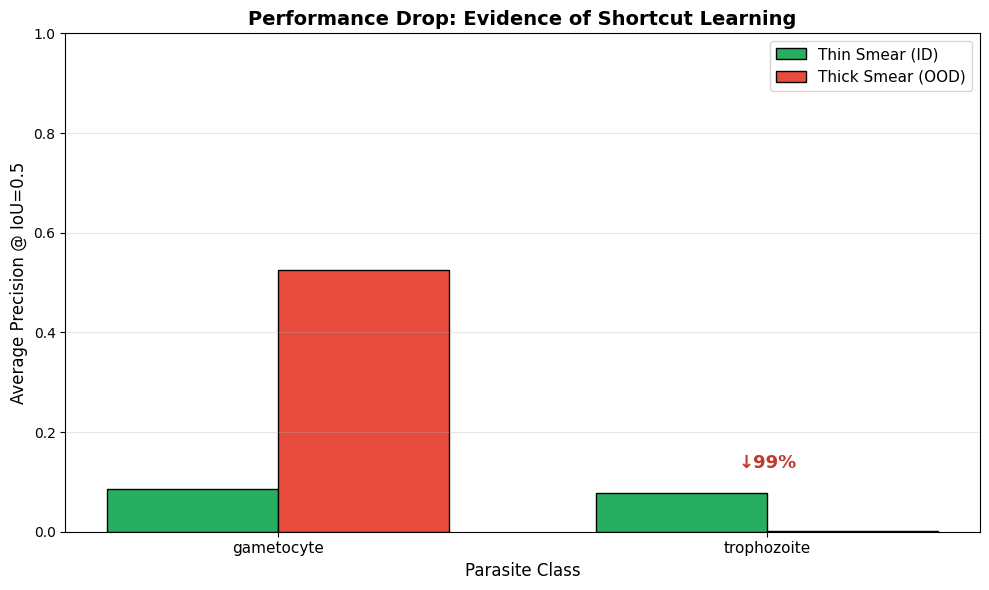


📊 Saved: /content/drive/MyDrive/Datasets/malaria_results/performance_comparison.png


In [ ]:
# Create comparison bar chart
import matplotlib.pyplot as plt
import numpy as np

# Filter to comparable classes (in both datasets)
eval_classes = [d for d in comparison_data if d['in_thick'] and d['ood_ap50'] is not None]

if eval_classes:
    labels = [d['class'] for d in eval_classes]
    id_vals = [d['id_ap50'] for d in eval_classes]
    ood_vals = [d['ood_ap50'] for d in eval_classes]
    drops = [d['drop_pct'] for d in eval_classes]

    x = np.arange(len(labels))
    width = 0.35

    fig, ax = plt.subplots(figsize=(10, 6))

    bars1 = ax.bar(x - width/2, id_vals, width, label='Thin Smear (ID)',
                   color='#27ae60', edgecolor='black')
    bars2 = ax.bar(x + width/2, ood_vals, width, label='Thick Smear (OOD)',
                   color='#e74c3c', edgecolor='black')

    ax.set_ylabel('Average Precision @ IoU=0.5', fontsize=12)
    ax.set_xlabel('Parasite Class', fontsize=12)
    ax.set_title('Performance Drop: Evidence of Shortcut Learning',
                 fontsize=14, fontweight='bold')
    ax.set_xticks(x)
    ax.set_xticklabels(labels, fontsize=11)
    ax.legend(fontsize=11)
    ax.set_ylim(0, 1.0)
    ax.grid(axis='y', alpha=0.3)

    # Add drop annotations
    for i, (id_v, ood_v, drop) in enumerate(zip(id_vals, ood_vals, drops)):
        if drop and drop > 0:
            ax.annotate(f'↓{drop:.0f}%', xy=(x[i], max(id_v, ood_v) + 0.05),
                       ha='center', fontsize=13, color='#c0392b', fontweight='bold')

    plt.tight_layout()
    plt.savefig(f"{RESULTS_DIR}/performance_comparison.png", dpi=300, bbox_inches='tight')
    plt.savefig(f"{RESULTS_DIR}/performance_comparison.pdf", bbox_inches='tight')
    plt.show()

    print(f"\n📊 Saved: {RESULTS_DIR}/performance_comparison.png")
else:
    print("No comparable classes found.")

## 6. Attribution Analysis (Grad-CAM)

Visualize where the model focuses when making predictions.

In [ ]:
import torch
import cv2
import numpy as np
import matplotlib.pyplot as plt
from pytorch_grad_cam import EigenCAM
from pytorch_grad_cam.utils.image import show_cam_on_image
from ultralytics import YOLO
import warnings
warnings.filterwarnings('ignore')

class YOLOGradCAM:
    def __init__(self, model_path):
        self.model = YOLO(model_path)
        self.torch_model = self.model.model
        self.target_layers = [self.torch_model.model[-2]]
        self.cam = EigenCAM(
            self.torch_model,
            self.target_layers,
            use_cuda=torch.cuda.is_available()
        )

    def generate(self, image_path, size=640):
        img = cv2.imread(image_path)
        img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
        img = cv2.resize(img, (size, size))
        img_float = np.float32(img) / 255.0

        tensor = torch.from_numpy(img_float).permute(2, 0, 1).unsqueeze(0)
        grayscale_cam = self.cam(tensor)[0, :, :]
        overlay = show_cam_on_image(img_float, grayscale_cam, use_rgb=True)

        return img, grayscale_cam, overlay

# Initialize
gradcam = YOLOGradCAM(best_model_path)
print("✓ Grad-CAM ready!")

✓ Grad-CAM ready!


No objects detected in 871.jpg. Returning empty CAM.
No target objects (filtered by category 0) found in 1215.jpg. Returning empty CAM.


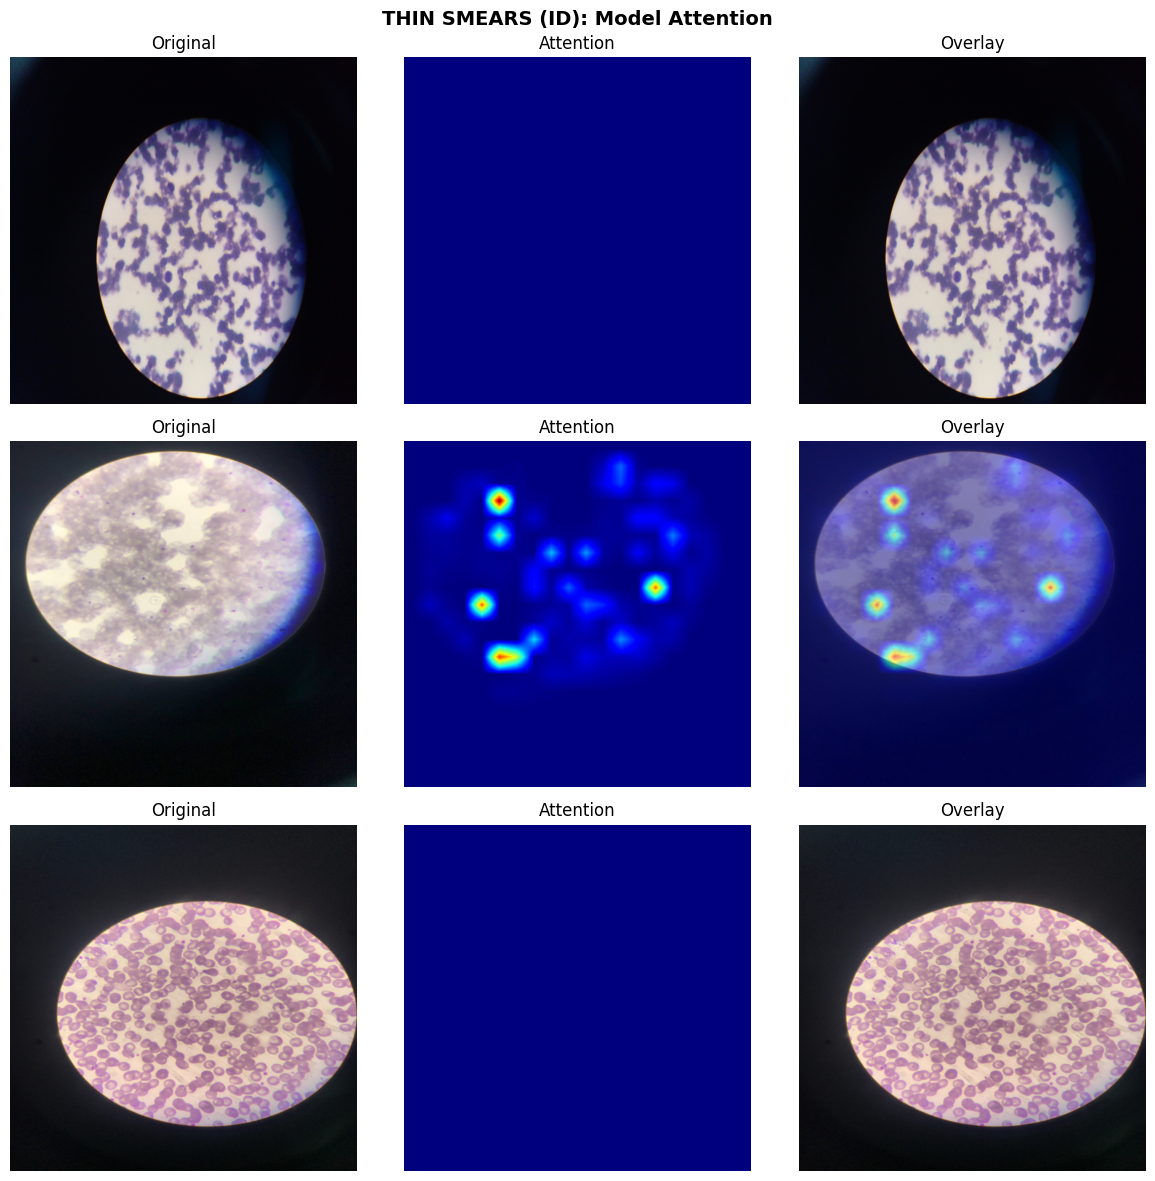

In [ ]:
# Get sample images
thin_imgs = glob(f"{OUTPUT_ROOT}/thin_smear/val/images/*.[jJ][pP][gG]")[:3]
thick_imgs = glob(f"{OUTPUT_ROOT}/thick_smear_test/images/*.[jJ][pP][gG]")[:3]

# Generate heatmaps for thin smears
fig, axes = plt.subplots(len(thin_imgs), 3, figsize=(12, 4*len(thin_imgs)))

for i, img_path in enumerate(thin_imgs):
    orig, heatmap, overlay = gradcam.generate(img_path)
    axes[i, 0].imshow(orig)
    axes[i, 0].set_title('Original')
    axes[i, 0].axis('off')
    axes[i, 1].imshow(heatmap, cmap='jet')
    axes[i, 1].set_title('Attention')
    axes[i, 1].axis('off')
    axes[i, 2].imshow(overlay)
    axes[i, 2].set_title('Overlay')
    axes[i, 2].axis('off')

plt.suptitle('THIN SMEARS (ID): Model Attention', fontsize=14, fontweight='bold')
plt.tight_layout()
plt.savefig(f"{RESULTS_DIR}/gradcam_thin.png", dpi=150)
plt.show()

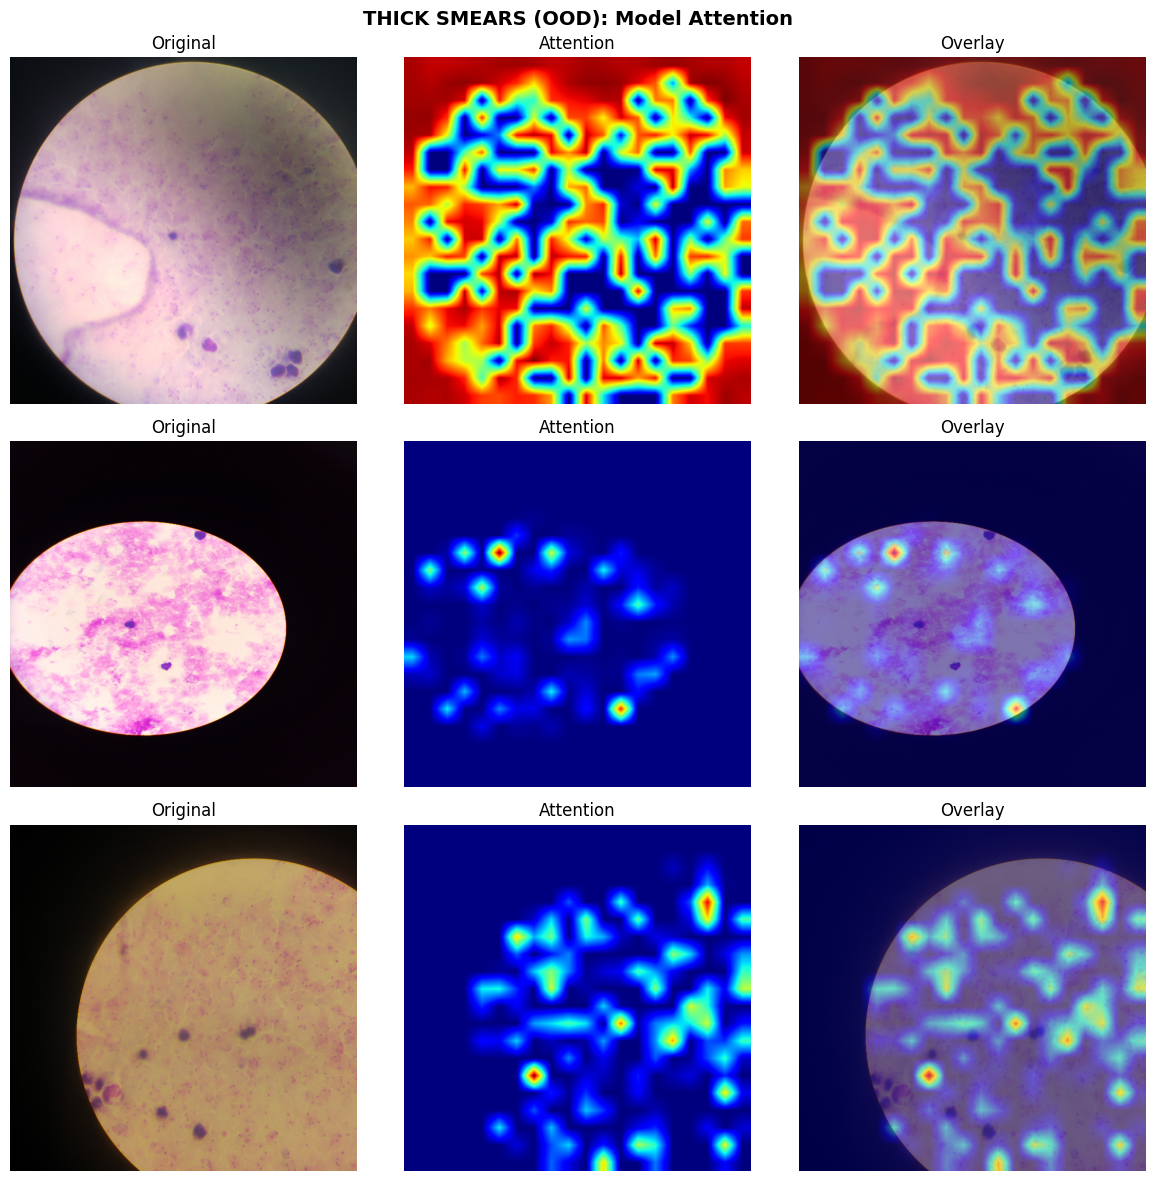


💡 INTERPRETATION:
  Red/Yellow = High attention | Blue = Low attention
  Compare: Does model focus on parasites or background?


In [ ]:
# Generate heatmaps for thick smears
fig, axes = plt.subplots(len(thick_imgs), 3, figsize=(12, 4*len(thick_imgs)))

for i, img_path in enumerate(thick_imgs):
    orig, heatmap, overlay = gradcam.generate(img_path)
    axes[i, 0].imshow(orig)
    axes[i, 0].set_title('Original')
    axes[i, 0].axis('off')
    axes[i, 1].imshow(heatmap, cmap='jet')
    axes[i, 1].set_title('Attention')
    axes[i, 1].axis('off')
    axes[i, 2].imshow(overlay)
    axes[i, 2].set_title('Overlay')
    axes[i, 2].axis('off')

plt.suptitle('THICK SMEARS (OOD): Model Attention', fontsize=14, fontweight='bold')
plt.tight_layout()
plt.savefig(f"{RESULTS_DIR}/gradcam_thick.png", dpi=150)
plt.show()

print("\n💡 INTERPRETATION:")
print("  Red/Yellow = High attention | Blue = Low attention")
print("  Compare: Does model focus on parasites or background?")

No objects detected in 871.jpg. Returning empty CAM.


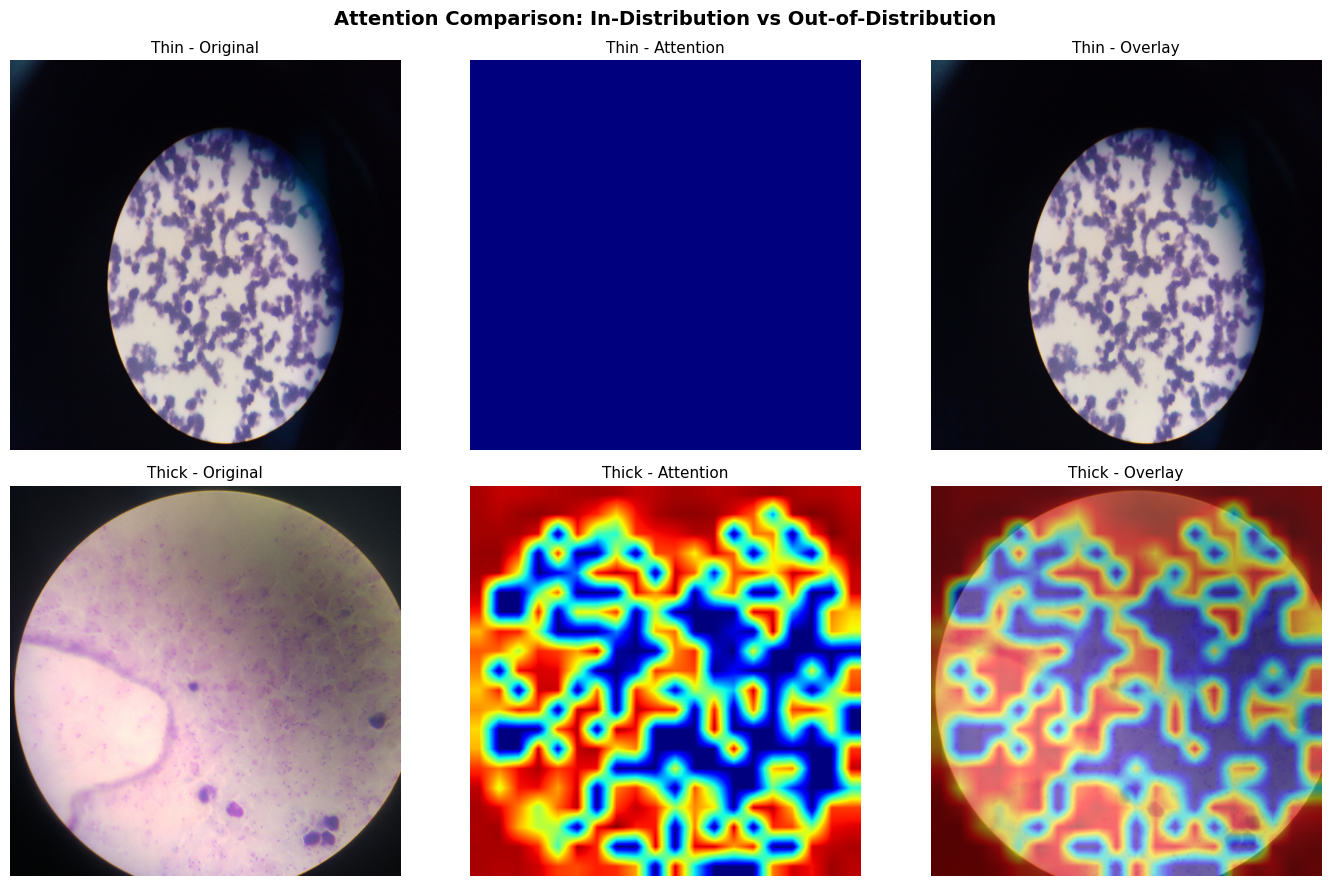


📊 Saved: /content/drive/MyDrive/Datasets/malaria_results/gradcam_comparison.png


In [ ]:
# Side-by-side comparison figure (for presentation)
fig, axes = plt.subplots(2, 3, figsize=(14, 9))

# Thin smear
orig, heatmap, overlay = gradcam.generate(thin_imgs[0])
axes[0, 0].imshow(orig)
axes[0, 0].set_title('Thin - Original', fontsize=11)
axes[0, 0].axis('off')
axes[0, 1].imshow(heatmap, cmap='jet')
axes[0, 1].set_title('Thin - Attention', fontsize=11)
axes[0, 1].axis('off')
axes[0, 2].imshow(overlay)
axes[0, 2].set_title('Thin - Overlay', fontsize=11)
axes[0, 2].axis('off')

# Thick smear
orig, heatmap, overlay = gradcam.generate(thick_imgs[0])
axes[1, 0].imshow(orig)
axes[1, 0].set_title('Thick - Original', fontsize=11)
axes[1, 0].axis('off')
axes[1, 1].imshow(heatmap, cmap='jet')
axes[1, 1].set_title('Thick - Attention', fontsize=11)
axes[1, 1].axis('off')
axes[1, 2].imshow(overlay)
axes[1, 2].set_title('Thick - Overlay', fontsize=11)
axes[1, 2].axis('off')

plt.suptitle('Attention Comparison: In-Distribution vs Out-of-Distribution',
             fontsize=14, fontweight='bold')
plt.tight_layout()
plt.savefig(f"{RESULTS_DIR}/gradcam_comparison.png", dpi=300, bbox_inches='tight')
plt.savefig(f"{RESULTS_DIR}/gradcam_comparison.pdf", bbox_inches='tight')
plt.show()

print(f"\n📊 Saved: {RESULTS_DIR}/gradcam_comparison.png")

## 7. Summary & Export

In [ ]:
# Final summary
print("="*70)
print("EXPERIMENT SUMMARY")
print("="*70)

print(f"""
RESEARCH QUESTION:
Do YOLO models trained on thin smears rely on visual shortcuts,
failing to generalize to thick smears?

SETUP:
• Model: YOLOv8{MODEL_SIZE}
• Training: {train_n} thin smear images
• Validation (ID): {val_n} thin smear images
• Test (OOD): {test_n} thick smear images

KEY RESULTS:
• mAP@0.5 on Thin (ID):  {id_map50:.4f}
• mAP@0.5 on Thick (OOD): {ood_map50:.4f}
• Performance Drop: {drop:.1f}%

CONCLUSION:
The {drop:.1f}% performance drop suggests the model learned
smear-type-specific features (shortcuts) rather than robust
parasite morphology.

FILES GENERATED:
""")

for f in sorted(os.listdir(RESULTS_DIR)):
    if os.path.isfile(os.path.join(RESULTS_DIR, f)):
        print(f"  • {f}")

print(f"\n📁 All results at: {RESULTS_DIR}")

EXPERIMENT SUMMARY

RESEARCH QUESTION:
Do YOLO models trained on thin smears rely on visual shortcuts,
failing to generalize to thick smears?

SETUP:
• Model: YOLOv8n
• Training: 808 thin smear images
• Validation (ID): 203 thin smear images
• Test (OOD): 3045 thick smear images

KEY RESULTS:
• mAP@0.5 on Thin (ID):  0.3150
• mAP@0.5 on Thick (OOD): 0.2627
• Performance Drop: 98.8%

CONCLUSION:
The 98.8% performance drop suggests the model learned
smear-type-specific features (shortcuts) rather than robust
parasite morphology.

FILES GENERATED:

  • gradcam_comparison.pdf
  • gradcam_comparison.png
  • gradcam_thick.png
  • gradcam_thin.png
  • performance_comparison.csv
  • performance_comparison.pdf
  • performance_comparison.png
  • thin_vs_thick_comparison.png

📁 All results at: /content/drive/MyDrive/Datasets/malaria_results
